<a href="https://colab.research.google.com/github/Hunter-R-S/MAT494/blob/main/Recessions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recessions**
MAT 494 Final Project

Hunter Stephan

In [2]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)



import matplotlib.pyplot as plt
%matplotlib inline

Pulling data from FRED post 1974 and manipulating CPI, house prices, and employment to show year over year change as a percentage:

In [73]:
start = "1974-01-01"
end = datetime.date.today()

def pct_change_yearly(df):
    "Compute pct_change on previous year, assuming quarterly:"
    return (df - df.shift(4))/df.shift(4)

fred_load_a =  (
    web.DataReader(["USRECQ", "DFF", "T10Y2Y"], "fred", start, end)
    .resample("QS")
    .mean()
)

fred_load_b =  (
    web.DataReader(["PAYEMS", "CPIAUCSL", "USSTHPI"], "fred", start, end)
    .resample("QS")
    .mean()
    .pipe(pct_change_yearly)
    .dropna()
)

fred_data = (
    fred_load_a
    .join(fred_load_b)
    .dropna().rename(columns=dict(
            USRECQ = "Recession",
            DFF = "Rate",
            PAYEMS = "Employment",
            CPIAUCSL = "CPI",
            T10Y2Y="Yield_Curve",
            USSTHPI ="House_Prices"
    ))
)

fred_data.head()

,Recession,Rate,Yield_Curve,Employment,CPI,House_Prices
DATE,,,,,,
1976-04-01,0.0,5.195385,0.801364,0.036476,0.060150,0.073303
1976-07-01,0.0,5.283478,1.099687,0.034575,0.055897,0.088158
1976-10-01,0.0,4.874239,1.467377,0.031542,0.051870,0.080360
1977-01-01,0.0,4.660667,1.332222,0.028354,0.059034,0.105648
1977-04-01,0.0,5.157473,1.248254,0.034978,0.067967,0.111230


In [71]:
fred_data.tail()

,Recession,Rate,Yield_Curve,Employment,CPI,House_Prices
DATE,,,,,,
2021-04-01,0.0,0.068242,1.416562,0.085230,0.048132,0.124167
2021-07-01,0.0,0.090000,1.099063,0.045625,0.052905,0.166476
2021-10-01,0.0,0.079457,1.001613,0.043307,0.067213,0.180276
2022-01-01,0.0,0.121444,0.486613,0.046114,0.080004,0.194969
2022-04-01,0.0,0.766813,0.212097,0.044093,0.085806,0.208776


We can create recession bands to inlay our data on visually:

In [74]:
def get_recession_data():
    recession = (
        web.DataReader(["USRECQ"], "fred", start, end)
        .rename(columns=dict(USRECQ="recession"))
        ["recession"]
    )

    # extract start and end date for each recession
    start_dates = recession.loc[recession.diff() > 0].index.tolist()
    if recession.iloc[0] > 0:
        start_dates = [recession.index[0]] + start_dates

    end_dates = recession.loc[recession.diff() < 0].index.tolist()

    if (len(start_dates) != len(end_dates)) and (len(start_dates) != len(end_dates) + 1):
        raise ValueError("Need to have same number of start/end dates!")

    return recession, start_dates, end_dates

recession, start_dates, end_dates = get_recession_data()

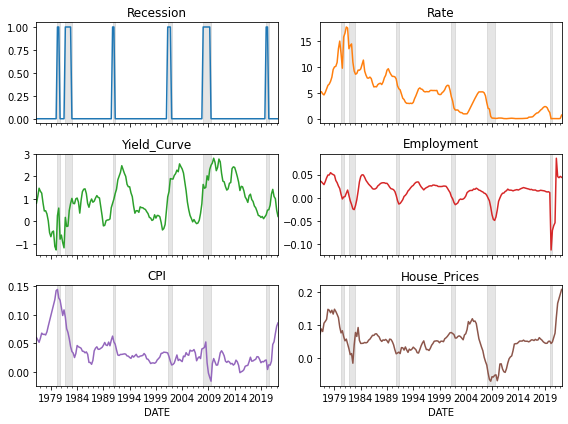

In [75]:
def add_recession_bands(ax):
    for s, e in zip(start_dates, end_dates):
        ax.axvspan(s, e, color="grey", alpha=0.2)

axs = fred_data.plot(subplots=True, figsize=(8, 6), layout=(3, 2), legend=False)

for i, ax in enumerate(axs.flatten()):
    add_recession_bands(ax)
    ax.set_title(list(fred_data)[i])

fig = axs[0, 0].get_figure()
fig.tight_layout();

Regressing Recessions against the Yield Curve:

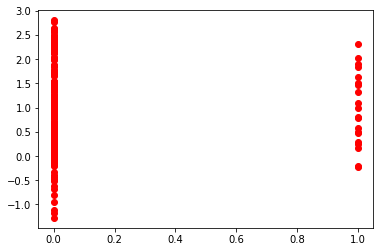

In [19]:
plt.scatter(fred_data["Recession"],fred_data["Yield_Curve"], color='red')

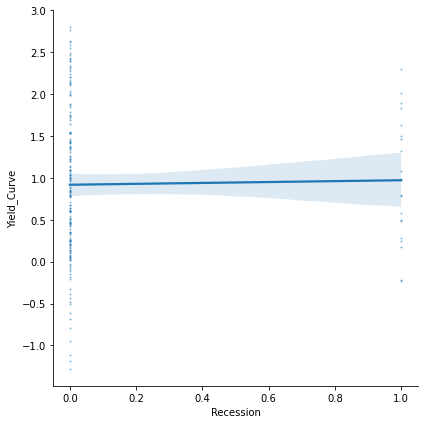

In [20]:
sns.lmplot(
    data=fred_data, x="Recession", y="Yield_Curve", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
);

In [61]:
Y = fred_data["Recession"].values.reshape(-1,1)
X = fred_data["Yield_Curve"].values.reshape(-1,1)

regr = linear_model.LinearRegression()
regr.fit(X,Y)

LinearRegression()

In [62]:
print(regr.intercept_)

[0.10192251]


In [63]:
print(regr.coef_)

[[0.00669128]]


In [60]:
import statsmodels.api as sm

model = sm.OLS(fred_data["Recession"].values.reshape(-1,1),fred_data["Yield_Curve"].values.reshape(-1,1)).fit()
predications = model.predict(fred_data["Yield_Curve"].values.reshape(-1,1))

print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.063
Model:                            OLS   Adj. R-squared (uncentered):              0.058
Method:                 Least Squares   F-statistic:                              12.32
Date:                Mon, 28 Nov 2022   Prob (F-statistic):                    0.000565
Time:                        01:59:42   Log-Likelihood:                         -50.733
No. Observations:                 185   AIC:                                      103.5
Df Residuals:                     184   BIC:                                      106.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Using MLR with all of the variables against the binary variable Recession:

In [64]:
Y2 = fred_data["Recession"].values.reshape(-1,1)
X2 = fred_data[["Yield_Curve", "House_Prices", "Rate", "Employment", "CPI"]]

model2 = sm.OLS(Y2,X2).fit()
predications = model.predict(X)

print_model2 = model2.summary()
print(print_model2)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.367
Model:                            OLS   Adj. R-squared (uncentered):              0.349
Method:                 Least Squares   F-statistic:                              20.87
Date:                Mon, 28 Nov 2022   Prob (F-statistic):                    2.01e-16
Time:                        02:03:28   Log-Likelihood:                         -14.430
No. Observations:                 185   AIC:                                      38.86
Df Residuals:                     180   BIC:                                      54.96
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

We can use the Markov Switching Model from Hamilton (1989) to show recession probabilities against the data:

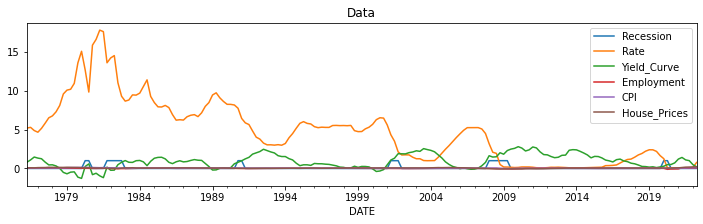

In [76]:
fred_data.plot(title='Data', figsize=(12,3))

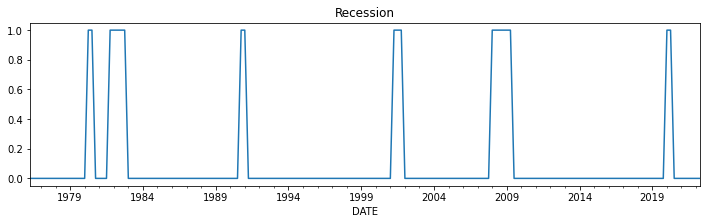

In [55]:
fred_data['Recession'].plot(title='Recession', figsize=(12,3))

In [102]:
def multiply(df):
    return (df*100)

fred_load_c =  (
    web.DataReader(["GNPC96"], "fred", start, end)
    .resample("QS")
    .mean()
    .pipe(pct_change_yearly)
    .pipe(multiply)
    .dropna()
)

GNP = (
    fred_load_c.rename(columns=dict(
            GNPC96 = "GNP"))
)


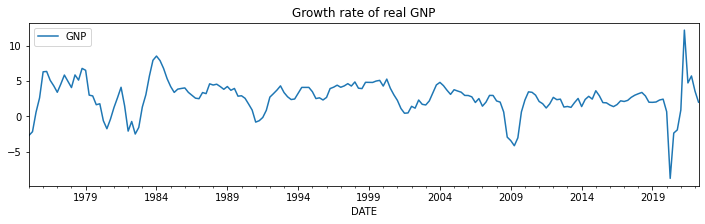

In [103]:
GNP.plot(title='Growth rate of real GNP', figsize=(12,3))

In [118]:
mod_hamilton = sm.tsa.MarkovAutoregression(GNP['GNP'], k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [121]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                      GNP   No. Observations:                  186
Model:             MarkovAutoregression   Log Likelihood                -337.745
Date:                  Mon, 28 Nov 2022   AIC                            693.490
Time:                          04:09:08   BIC                            722.521
Sample:                      01-01-1975   HQIC                           705.254
                           - 04-01-2022                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7062      0.360      7.522      0.000       2.001       3.411
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7063      0.434      6.235      0.000       1.856       3.557
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.2117      0.229      9.644      0.000       1.762       2.661
ar.L1          0.7119      0.071     10.029      0.000       0.573       0.851
ar.L2          0.1272      0.088      1.445      0.149      -0.045       0.300
ar.L3         -0.0180      0.088     -0.203      0.839      -0.191       0.155
ar.L4         -0.2520      0.070     -3.587      0.000      -0.390      -0.114
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.4992   5936.728   8.41e-05      1.000   -1.16e+04    1.16e+04
p[1->0]        0.4479        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

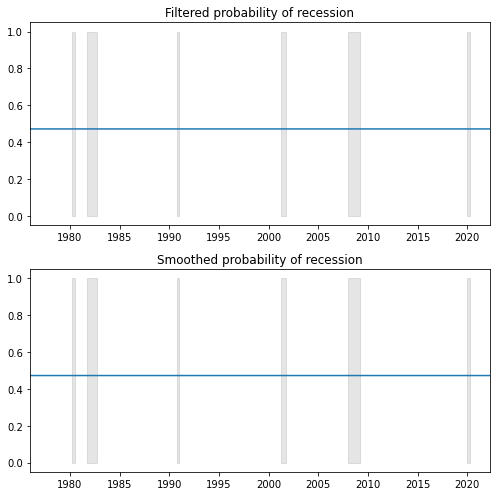

In [131]:
fig, axes = plt.subplots(2, figsize=(7,7))
ax = axes[0]
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.fill_between(fred_data['Recession'].index, 0, 1, where=fred_data['Recession'].values, color='k', alpha=0.1)
ax.set_xlim(GNP['GNP'].index[4], GNP['GNP'].index[-1])
ax.set(title='Filtered probability of recession')

ax = axes[1]
ax.plot(res_hamilton.smoothed_marginal_probabilities[0])
ax.fill_between(fred_data['Recession'].index, 0, 1, where=fred_data['Recession'].values, color='k', alpha=0.1)
ax.set_xlim(GNP['GNP'].index[4], GNP['GNP'].index[-1])
ax.set(title='Smoothed probability of recession')

fig.tight_layout()

In [125]:
print(res_hamilton.expected_durations)

[1.99669822 2.23242025]


In [127]:
res_hamilton.filtered_marginal_probabilities.tail()

,0,1
DATE,,
2021-04-01,0.472042,0.527958
2021-07-01,0.472188,0.527812
2021-10-01,0.472143,0.527857
2022-01-01,0.472151,0.527849
2022-04-01,0.472124,0.527876


In [128]:
res_hamilton.smoothed_marginal_probabilities.tail()

,0,1
DATE,,
2021-04-01,0.471997,0.528003
2021-07-01,0.472179,0.527821
2021-10-01,0.472131,0.527869
2022-01-01,0.472156,0.527844
2022-04-01,0.472124,0.527876
